# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array
import scipy.sparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run data_tools.ipynb

In [3]:
recbe_wiring_file = "~/development/ICEDUST/track-finding-yandex/data/chanmap_20160814.root"
recbe_positions = root2array(recbe_wiring_file, selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19", 
                                        branches=["LayerID", "CellID","BoardID",
                                                  "BrdLayID", "BrdLocID","ChanID"])
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

# Signal Data

In [4]:
file_root = "~/development/ICEDUST/track-finding-yandex/data/MC4p/"

back_samples = ["MC4p_background_sample_3bunch-train_1.root",
                "MC4p_background_sample_3bunch-train_2.root",
                "MC4p_background_sample_3bunch-train_3.root",
                "MC4p_background_sample_3bunch-train_4.root"]
sig_samples = [
    "oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09410000-0000_z2p5ysva45vx_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09510000-0000_3eox62hw5ygi_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09610000-0000_7ctgq54tptae_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09710000-0000_kah3t5htgouf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09810000-0000_a4tlhqvqnv4p_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09910000-0000_h6g347twij7d_user-TrkTree_000_500signal-label.root"]

sig_samples_700 = [
    "oa_xx_xxx_09010000-0000_bgd5wd5uhw2n_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09110000-0000_fiey62djp4gd_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09210000-0000_chqno3g2fxqs_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09310000-0000_paynw633hzqk_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09410000-0000_kd234xkjqddc_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09510000-0000_lpd33ym64roi_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09610000-0000_i37ocps322kr_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09710000-0000_t2l7rgghqqdq_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09810000-0000_mzoackf2gbk7_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09910000-0000_cbwuzp2l4inz_user-TrkTree_000_700signal-label.root"]

back_samples = [file_root + this_file for this_file in back_samples]
sig_samples = [file_root + this_file for this_file in sig_samples_700]

In [5]:
import root_numpy

In [6]:
these_branches = {}
these_branches["CDC"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]
these_branches["CTH"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]

In [7]:
train_s = data_import_sample(sig_samples[0], back_samples[0], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
test_s = data_import_sample(sig_samples[1], back_samples[1], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
train_s.cth.set_trigger_time()
test_s.cth.set_trigger_time()
data_remove_coincidence(train_s)
data_remove_coincidence(test_s)

Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && '
         'CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > '
         '700'}


TClass::Init:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::IDataVector is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::IData is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::IDatum is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::ICOMETContext is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::ISHAHashValue is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::IAlignmentId is available
TClass::Init:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent::Header is available


Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && '
         'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && '
         'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Background Events
CTH Sig Events 2856 
CDC Sig Events 2856 
CDC Back Events 2856 
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && '
         'CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > '
         '700'}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && '
         'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && 

## Define Training Sample For Track Finding

In [8]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [9]:
# Split up the data first
from sklearn.model_selection import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train_s.cdc.n_events)
sample_1, sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
evt_samp       = [ np.sort(sample_1), np.sort(sample_2) ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_s.cdc)

In [10]:
# Get samples
# TODO clean me up a lot
test_s_rest = range(test_s.cdc.n_events)
test_s_sample_1, test_s_sample_2 = train_test_split(test_s_rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
test_s_evt_samp       = [ np.sort(test_s_sample_1), np.sort(test_s_sample_2) ]
test_s_evt_samp_masks, test_s_hit_masks = reset_masks(test_s_evt_samp, test_s.cdc)

# Look at features

In [11]:
from jupyterthemes import jtplot
%run visualizations.ipynb

jtplot.style(grid=False, ticks=True, fscale=1.4)
jtplot.figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
import matplotlib as mpl
mpl.rcParams['legend.facecolor'] = 'inherit'

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


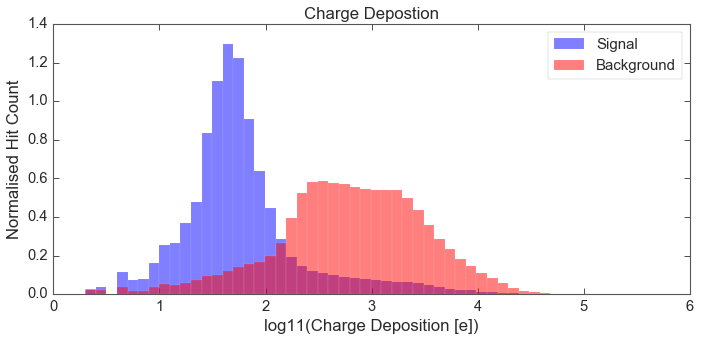

In [13]:
bins_for_plots = 50
plot_feature( np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] + 1), 
              np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] + 1), 
              xlabel="log11(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion",
              nbins=bins_for_plots)
show()

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


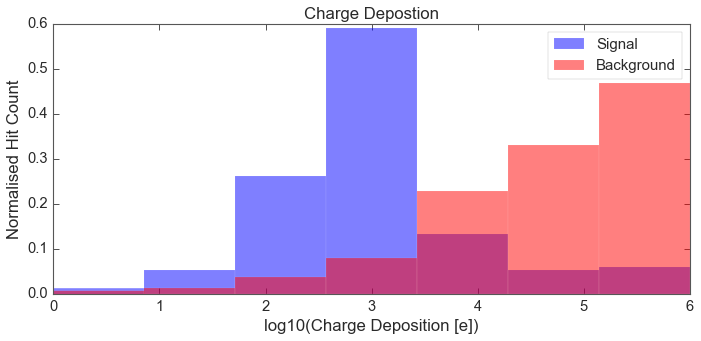

In [14]:
bins_for_plots = 50
powered_bins = np.array([3.150, 
                         10.000, 31.50,
                         100.00, 315.0,
                         1000.0])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=7,
              uniform_bins=False)
show()

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


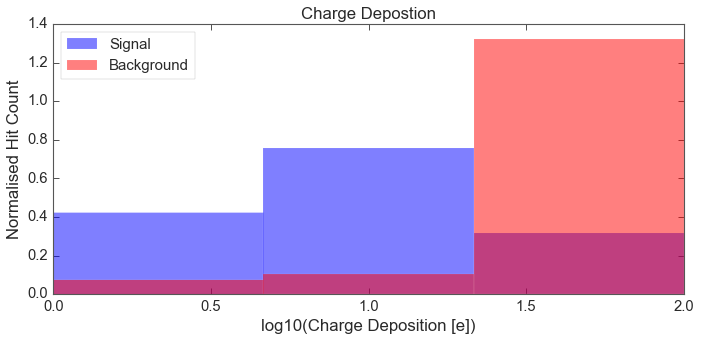

In [15]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=3,
              uniform_bins=False,
              override_bins=None)
show()

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


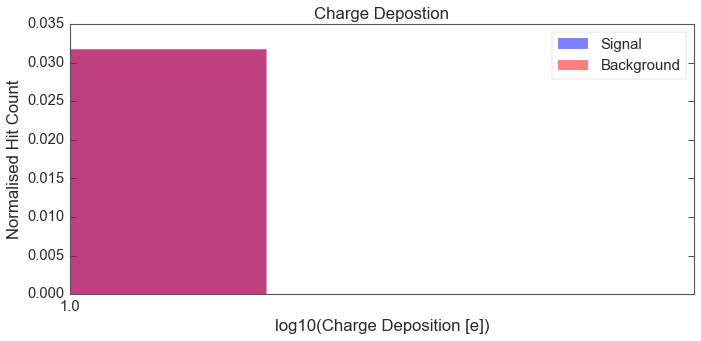

In [16]:
bins_for_plots = 50
powered_bins = np.array([0.0, 31.5, 100])
plot_feature( train_s.cdc.get_signal_hits()[train_s.cdc.edep_name],
              train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=True,
              title="Charge Depostion", 
              nbins=10,
              uniform_bins=True,
              override_bins=powered_bins)
show()

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


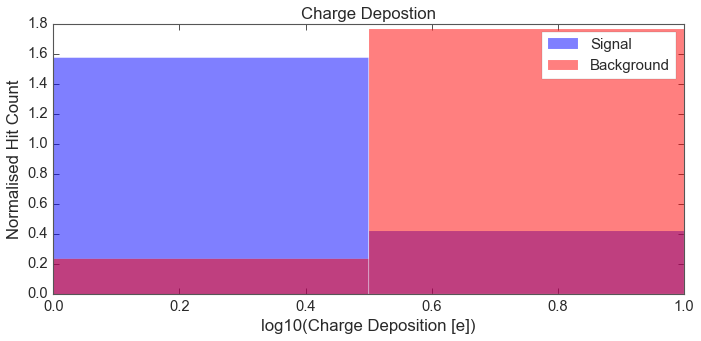

In [17]:
bins_for_plots = 50
plot_feature( np.digitize(np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              np.digitize(np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=2,
              uniform_bins=False)
show()

In [18]:
print(recbe_positions)

[(0, 0, 0, 0, 0, 2) (0, 1, 0, 0, 0, 1) (0, 2, 0, 0, 0, 3) ...,
 (17, 297, 103, 5, 17, 43) (17, 298, 103, 5, 17, 45)
 (17, 299, 103, 5, 17, 47)]


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


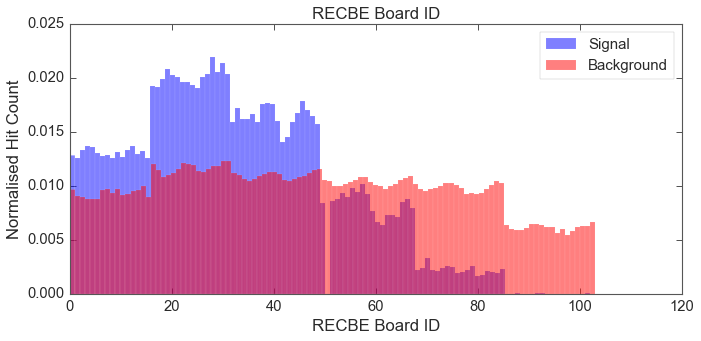

In [19]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature(recbe_positions["BoardID"][train_s.cdc.get_signal_hits()[train_s.cdc.flat_name]],
             recbe_positions["BoardID"][train_s.cdc.get_background_hits()[train_s.cdc.flat_name]], 
              xlabel="RECBE Board ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="RECBE Board ID", 
              nbins=104,
              uniform_bins=False)
show()

Sig Occ: 84.37643961829549 , Back Occ : 490.4300756827904
All Occ: 574.8065153010859, 0.12824777226708745
NumHits: 574.8065153010859
MinChansMultiHit: 0.0


/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


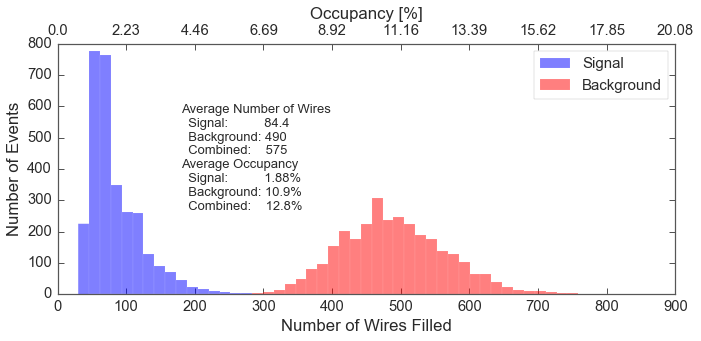

In [20]:
sig_occ, back_occ, occ = data_get_occupancy(test_s.cdc) 
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.2, y_pos=0.76)

## Define Wire Features 

In [21]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

/home/elg112/development/miniconda2/envs/rep3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
# Define Data
energy_feature = "Energy"
binary_energy = energy_feature + "_one_bit"
binned_energy = energy_feature+ "_two_bit"
high_bin_energy = energy_feature+ "_three_bit"
energy_feature = energy_feature + "_unbin"
board_id = "RECBE_id"
board_layer = "RECBE_layer"
layer_id = "Layer_ID"

binary_wire_features = [binary_energy, 
                        binary_energy + "_left",
                        binary_energy + "_right"]
binned_wire_features = [binned_energy, 
                        binned_energy + "_left",
                        binned_energy + "_right"]
high_bin_wire_features = [high_bin_energy, 
                          high_bin_energy + "_left",
                          high_bin_energy + "_right"]
unbin_wire_features = [energy_feature, 
                       energy_feature + "_left",
                       energy_feature + "_right"]
all_features = binary_wire_features + \
               binned_wire_features + \
               high_bin_wire_features + \
               unbin_wire_features + \
               [board_id, board_layer, layer_id]

In [23]:
factory = ClassifiersFactory()

# Define GBDT for ADC
binary_energy = SklearnClassifier(GradientBoostingClassifier(n_estimators=100),
                                  features=[energy_feature])
factory.add_classifier('ADC', binary_energy)
# Define GBDT for 1 bits
binary_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binary_wire_features + [board_id])
factory.add_classifier('Binary', binary_neighs)
# Define GBDT for 2 bits
binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binned_wire_features + [board_id])
factory.add_classifier('Binned', binned_neighs)
# Define GBDT for 2 bits
high_binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=high_bin_wire_features + [board_id])
factory.add_classifier('High_Binned', high_binned_neighs)
# Define GBDT over unbinned wire features
unbin_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=unbin_wire_features + [layer_id])
factory.add_classifier('Unbinned', unbin_neighs)

In [24]:
print(train_s.cdc.n_hits, train_s.cdc.n_events)
print(train_s.cdc.get_measurement(train_s.cdc.hit_type_name).shape)

1636433 2856
(1636433,)


In [ ]:
def get_data_frame(samp, events):
    flat_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=events).astype(int)
    return DataFrame(np.vstack(
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[100], default=1) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1, 31.5, 100], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1.0000, 3.150, 
                                                                           10.000, 31.50,
                                                                           100.00, 315.0,
                                                                           1000.0], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events) +\
                        [recbe_positions["BoardID" ][flat_ids]] +\
                        [recbe_positions["BrdLayID"][flat_ids]] +\
                        [samp.cdc.geom.get_layers(flat_ids)]).T, columns=all_features)

In [ ]:
# Train the classifier
factory.fit(get_data_frame(train_s, evt_samp[0]),
            train_s.cdc.get_measurement(train_s.cdc.hit_type_name, events=evt_samp[0]))

model ADC          was trained in 91.28 seconds
model Binary       was trained in 98.53 seconds
model Binned       was trained in 113.54 seconds


In [ ]:
# Test the classifier
bbdt_diagnostics = \
    factory.test_on(get_data_frame(test_s, test_s_evt_samp[0]), 
                    test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0]))

In [ ]:
bins_for_plots = 50
plot_feature( bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 1.0,1],
              bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 0.0,1],
              xlabel="Classification Score", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Unbinned GBDT Score", 
              nbins=bins_for_plots,
              uniform_bins=True)
show()

In [ ]:
f_size = 10
plot_set_font(size=f_size)
curve_dict = dict()

cla_dict = {}
cla_dict["ADC"] = "ADC Only (Unbinned)"
cla_dict["Binary"] = "ADC And Neighbours (2 bins)"
cla_dict["Binned"] = "ADC And Neighbours (4 bins)"
cla_dict["High_Binned"] = "ADC And Neighbours (8 bins)"
cla_dict["Unbinned"] = "ADC And Neighbours (Unbinned)"
threshold_dict = {}


for cla in factory.keys():
    pred = None
    if cla == "ADC":
        pred =  1/np.log10(1+test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics.prediction[cla][:,1]
    plot_roc_curve(bbdt_diagnostics.target, 
                   pred,
                   label=cla_dict[cla],
                   zoom=True,
                   zoom_x_lims=[80,100],
                   zoom_y_lims=[50,100],
                   datum_label="Hit")

    print(cla)
    print("  {}".format(roc_auc_score(bbdt_diagnostics.target, 
                                      pred)))
    curve = roc_curve(bbdt_diagnostics.target,
                                pred)
    print("  {}".format(np.array(curve).shape))
    curve_dict[cla] = curve
    threshold_dict[cla] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]

pprint(threshold_dict)
plt.show()

### New Plot

Need (percentage of signal hits by event,
      percentage of background hits by event,
      score) 

Have (total signal hits,
      total background hits
      score)

In [ ]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types_1 = all_types[beg_hits:end_hits]
    hit_types_2 = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt)
    #print beg_hits, end_hits
    if not np.array_equal(hit_types_1, hit_types_2):
        print(evt)
        print("  {} {}".format(hit_types_1.shape, hit_types_2.shape))
        print("  {} {}".format(sum(hit_types_1 == 0.0), sum(hit_types_2 == 0.0)))
        print("  {} {}".format(sum(hit_types_1 == 1.0), sum(hit_types_2 == 1.0)))
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [ ]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types = all_types[beg_hits:end_hits]
    same = np.array_equal(hit_types, 
                          test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt))
    if not same:
        print(evt, sum(hit_types==1), sum(hit_types==0), beg_hits, end_hits)
    else:
        hit_types[hit_types==1] = 1./sum(hit_types==1)
        hit_types[hit_types==0] = 1./sum(hit_types==0)
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [ ]:
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    vals, index, counts =  np.unique(all_types[beg_hits:end_hits], 
                                     return_counts=True, return_index=True)
    if np.unique(np.round(vals*counts).astype(int))[0] != 1:
        print(evt)
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [ ]:
for cla in factory.keys():
    pred = None
    if cla == "ADC":
        pred =  1.0/np.log10(1+test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics.prediction[cla][:,1]
    cla_label = cla_dict[cla] + " event weight"
    plot_roc_curve(bbdt_diagnostics.target, 
                   pred,
                   label=cla_label,
                   zoom=True,
                   zoom_x_lims=[80,100],
                   zoom_y_lims=[80,100],
                   datum_label="Hit",
                   weights=all_types)

    print(cla_label)
    print("  {}".format(roc_auc_score(bbdt_diagnostics.target, pred, sample_weight=all_types)))
    curve = roc_curve(bbdt_diagnostics.target, pred, sample_weight=all_types)
    print("  {}".format(np.array(curve).shape))
    curve_dict[cla+"_Evt_W"] = curve
    threshold_dict[cla+"_Evt_W"] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]

pprint(threshold_dict)
plt.show()

In [ ]:
#train_s.cdc.data[train_s.cdc.prefix+pos[2]] = - (train_s.cdc.data[train_s.cdc.prefix+pos[2]]/10. - 765)
#train_s.cdc.data[train_s.cdc.prefix+pos[1]] = train_s.cdc.data[train_s.cdc.prefix+pos[1]]/10.
#train_s.cdc.data[train_s.cdc.prefix+pos[0]] = (train_s.cdc.data[train_s.cdc.prefix+pos[0]]/10. - 641)
#train_s.cth.data[train_s.cth.prefix+pos[2]] = - (train_s.cth.data[train_s.cth.prefix+pos[2]]/10. - 765)
#train_s.cth.data[train_s.cth.prefix+pos[1]] = train_s.cth.data[train_s.cth.prefix+pos[1]]/10.
#train_s.cth.data[train_s.cth.prefix+pos[0]] = (train_s.cth.data[train_s.cth.prefix+pos[0]]/10. - 641)

In [ ]:
pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train_s.cdc.prefix + pos[2]
p["cdc"]["y"] =  train_s.cdc.prefix + pos[1]
p["cdc"]["z"] =  train_s.cdc.prefix + pos[0]
p["cth"] = dict()
p["cth"]["x"] =  train_s.cth.prefix + pos[2]
p["cth"]["y"] =  train_s.cth.prefix + pos[1]
p["cth"]["z"] =  train_s.cth.prefix + pos[0]

In [ ]:
classifier = "Binned"
fig_s = (10,10)
s_scale = 35
plot_recbes = True
for evt in range(1775,1778):
    # Plot the output
    output = np.zeros(4482)
    geom_ids = test_s.cdc.get_measurement(test_s.cdc.flat_name, evt).astype(int)
    output[geom_ids] = factory.predict_proba(get_data_frame(test_s, evt))[classifier][:,1]
    cut = (output >= threshold_dict[classifier])

    for output, outline in zip([output, cut], [True,False]): 
        if not outline:
            plot_output(test_s.cdc.get_hit_types(evt),
                                      test_s.cdc.geom, size=output*s_scale, figsize=fig_s,
                        sig_color="Black", bkg_color="Black")
        # Add hit outlines
        if outline:
            plot_output(test_s.cdc.get_hit_types(evt),
                                      test_s.cdc.geom, size=output*s_scale, figsize=fig_s)
            plot_add_outlines(test_s.cdc.get_hit_types(evt), 
                              test_s.cdc.geom, size=s_scale)
        # Add volume outlines
        plot_add_cth_outlines(test_s.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = test_s.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, test_s.cth.get_trig_vector(evt)[0], test_s.cth.geom)
        cth_hits = test_s.cth.get_events(evt)
        cdc_hits = test_s.cdc.get_events(evt)
        plt.scatter(cth_hits[p["cth"]["x"]], 
                    cth_hits[p["cth"]["y"]], 
                    s=1, transform=gca().transData._b)
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)
        plt.show()
    print("=====================================================================")

## Get board, wire mapping

In [ ]:
recbe_wiring_file = "/home/elg112/development/ICEDUST/track_finding_standalone/"+\
                    "track_finding_yandex/data/chanmap_20160814.root"
recbe_positions = root_numpy.root2array(recbe_wiring_file, 
                                        selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19")
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

In [ ]:
wire_to_board = recbe_positions["BoardID"][test_s.cdc.geom.point_lookup[recbe_positions["LayerID"],
                                             recbe_positions["CellID"]]]
vals, index, inv =  np.unique(wire_to_board, 
                                 return_inverse=True, return_index=True)
board_to_wire = np.array([np.where(wire_to_board == val)[0] for val in vals])

## Examine the Boards

RECBE Level Classification:

* Features:
    * Sum of Scores (L/R)
    * Number of wires (L/R)
    * Layer ID
* Approaches:
    * Number of boards above threshold
    * Shape-based analysis
* Unused data:
    * Information from CTH trigger

## Import Event Sample

In [ ]:
sig_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)
bck_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)

In [ ]:
# Take out all signal hits fromt the background events
bck_evts.cdc.trim_hits(sig_evts.cdc.hit_type_name, values=[False])

In [ ]:
sig_evts.cth.set_trigger_time()
bck_evts.cth.set_trigger_time()

In [ ]:
data_remove_coincidence(sig_evts)
data_remove_coincidence(bck_evts)

### Classify Event Sample

In [ ]:
evt_scores = {}
evt_scores["Signal"] = {}
evt_scores["Background"] = {}
evt_scores["Signal"]["wires"] = {}
evt_scores["Background"]["wires"] = {}
evt_scores["Signal"]["boards"] = {}
evt_scores["Background"]["boards"] = {}

In [ ]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print(etype, cla)
        evt_scores[etype]["wires"][cla] = np.array([factory[cla].predict_proba(get_data_frame(samp, evt))[:,1]
                                                      for evt in range(samp.cdc.n_events)])

In [ ]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    print(etype, cla)
    evt_scores[etype]["wires"]["ADC_2"] = np.array([samp.cdc.get_measurement(samp.cdc.edep_name, 
                                                                         events=evt) < 100.0
                                                   for evt in range(samp.cdc.n_events)])

In [ ]:
plot_feature( np.array([sum(score) for score in evt_scores["Signal"]["wires"]["ADC_2"]]), 
              np.array([sum(score) for score in evt_scores["Background"]["wires"]["ADC_2"]]),
              xlabel="Number of Wires to Pass Cut", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to ADC Cut Classifier", 
              nbins=bins_for_plots)

In [ ]:
plot_feature( np.array([sum(score) for score in evt_scores["Signal"]["wires"]["Unbinned"]]), 
              np.array([sum(score) for score in evt_scores["Background"]["wires"]["Unbinned"]]),
              xlabel="Sum of Wire Score", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to Unbinned Classifier", 
              nbins=bins_for_plots)

In [ ]:
cla_dict["ADC_2"] = "ADC Cut (adc < 100e)"
evt_curve_dict= {}

labels = np.zeros(sig_evts.cdc.n_events + bck_evts.cdc.n_events)
labels[:sig_evts.cdc.n_events] = 1
for cla in evt_scores["Signal"]["wires"].keys():
    if cla == "ADC": continue
    sig_score = np.array([sum(score) for score in evt_scores["Signal"]["wires"][cla]])
    bkg_score = np.array([sum(score) for score in evt_scores["Background"]["wires"][cla]])
    #sig_score = sig_score/n_hits
    #bkg_score = bkg_score/n_hits
    plot_roc_curve(labels, np.append(sig_score,bkg_score),
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[80,100],
                   datum_label="Event")
    curve = roc_curve(labels, np.append(sig_score, bkg_score))
    evt_curve_dict[cla] = curve
plt.show()

## Get Board Information

In [ ]:
def get_board_info(samp, samp_score, event):
    # Get the wire IDs for all the hits
    flt_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=event).astype(int)
    # Get board scores by event
    board_sum = np.zeros(board_to_wire.shape[0], dtype=float)
    brd_ids = wire_to_board[flt_ids]
    for bID, scr in zip(brd_ids, samp_score[event]):
        board_sum[bID] += scr
    # Get the number of hits per board
    brd_nhits = np.zeros_like(board_sum)
    vals, counts = np.unique(wire_to_board[samp.cdc.get_hit_vols(event)], return_counts=True)
    brd_nhits[vals] += counts    
    # Get the board labels as "has signal hit"
    brd_label = np.zeros_like(board_sum)
    brd_label[wire_to_board[samp.cdc.get_bkg_vols(event)]] = 2
    brd_label[wire_to_board[samp.cdc.get_sig_vols(event)]] = 1
    return board_sum, brd_nhits, brd_label

In [ ]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in evt_scores[etype]["wires"].keys():
        evt_scores[etype]["boards"][cla] = np.vstack([
            np.dstack(get_board_info(samp, evt_scores[etype]["wires"][cla], evt)) 
            for evt in range(samp.cdc.n_events)])

In [ ]:
for cla in evt_scores["Signal"]["boards"].keys():
    board_labels = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,2],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,2])
    board_scores = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,0],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,0])
    print(numpy.unique(board_labels))
    sig_scores = board_scores[board_labels == 1]
    back_scores = board_scores[board_labels == 2]
    plot_feature( sig_scores, back_scores, 
                  xlabel="Board Score", ylabel="Number of Boards", 
                  xlog=False,
                  title="Board Scores for "+cla, 
                  nbins=bins_for_plots)
    plt.show()

In [ ]:
figsize(10,5)
for cla in evt_scores["Signal"]["boards"].keys():
    board_labels = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,2],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,2])
    board_scores = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,0],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,0])
    board_nhits = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,1],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,1])
    #board_scores = board_scores/board_nhits
    print(np.amax(board_scores))
    # Get the signal and back only board scores (no empties)
    sig_scores = board_scores[board_labels == 1]
    back_scores = board_scores[board_labels == 2]
    all_scores = np.append(sig_scores, back_scores)
    labels = np.zeros_like(all_scores)
    # Label these scores
    labels[range(len(sig_scores))] = 1
    plot_roc_curve(labels, all_scores,
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                   datum_label="Board")
    curve = roc_curve(labels, all_scores)
    print(roc_auc_score(labels, all_scores))
    #evt_curve_dict[cla] = curve
plt.show()

## Classify Events Using Board Location Agreement

In [ ]:
figsize(10,5)
pos_score = dict(dict())
pos_score["Signal"] = {}
pos_score["Background"] = {}


for etype in ["Signal", "Background"]:
    all_cla = evt_scores[etype]["boards"]
    for cla in all_cla.keys():
        # Store these values in a dictionary
        pos_score[etype][cla] = np.zeros(all_cla[cla].shape[0])
        for evt_idx, evt_brds in enumerate(all_cla[cla]):
            evt_x_pos = 0.
            evt_y_pos = 0.
            for brd_id, brd in enumerate(evt_brds):
                brd_phi = np.average(sig_evts.cdc.geom.point_phis[board_to_wire[brd_id]])
                if brd[1] != 0:
                    evt_x_pos += brd[0]*np.cos(brd_phi)
                    evt_y_pos += brd[0]*np.sin(brd_phi)
            pos_score[etype][cla][evt_idx] = np.sqrt(evt_x_pos*evt_x_pos + \
                                                     evt_y_pos*evt_y_pos)

In [ ]:
for cla in pos_score["Signal"].keys():
    sig_scores = pos_score["Signal"][cla]
    back_scores =  pos_score["Background"][cla]
    all_scores = np.append(sig_scores, back_scores)
    labels = np.zeros_like(all_scores)
    # Label these scores
    labels[range(len(sig_scores))] = 1
    plot_roc_curve(labels, all_scores,
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                   datum_label="Event")

In [ ]:
for cla in pos_score["Signal"].keys():
    sig_scores = pos_score["Signal"][cla]
    back_scores =  pos_score["Background"][cla]
    plot_feature( sig_scores, back_scores, 
                  xlabel="Board Score", ylabel="Number of Boards", 
                  xlog=False,
                  title="Event Scores for Board Location Agreement based on "+cla+" weighting", 
                  nbins=bins_for_plots)
    plt.show()

# Develop Board Hough

In [ ]:
import cylinder
reload(cylinder)
from cylinder import RECBE, CDC
from scipy.spatial import ConvexHull

In [ ]:
recbe_wiring_file = "/home/elg112/development/ICEDUST/track_finding_standalone/"+\
                    "track_finding_yandex/data/chanmap_20160814.root"
recbe_positions = root_numpy.root2array(recbe_wiring_file, 
                                        selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19")
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

In [ ]:
cydet_geom = sig_evts.cdc.geom
cydet_geom = CDC(projection=0.0)
new_recbe = RECBE(cydet_geom)
all_colour = np.linspace(0,1,104)
np.random.shuffle(all_colour)

In [ ]:
evt = 10
board_info = evt_scores["Background"]["boards"]["High_Binned"][evt]
print(board_info.shape)

# Hough Transform the Boards

In [ ]:
import tracking
reload(tracking)

In [ ]:
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter

In [ ]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(sig_evts.cdc.geom.recbe, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81, split=False)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [ ]:
new_correspondence.shape

In [ ]:
# Fit and transform the second data sample
fit_class = evt_scores["Signal"]["boards"]["High_Binned"]
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     fit_class[:,:,0]/(fit_class[:,:,1]+1),
                                     alpha_max=2., alpha_rw=1., min_percentile=0.97)

In [ ]:
for sig, bkg, key in zip(evt_scores["Signal"]["boards"].itervalues(),
                         evt_scores["Background"]["boards"].itervalues(),
                         evt_scores["Signal"]["boards"].keys()):
    # Labels 
    print(key)
    labels = np.zeros(sig.shape[0] + bkg.shape[0])
    labels[:sig.shape[0]] = 1
    # Scores
    scores = np.zeros_like(labels)
    scores = np.vstack([scores,scores])
    # Signal scores
    score = sig[:,:,0]/(sig[:,:,1]+1)
    trans_data, hough_images = \
            hough_transformer.transform(score, only_hits=False, flatten=False)
    print(np.amax(trans_data), np.amax(hough_images))
    scores[0,:sig.shape[0]]  = np.sum(trans_data, axis=1)
    scores[1,:sig.shape[0]]  = np.sum(hough_images, axis=1)
    # Background scroes
    score = bkg[:,:,0]/(bkg[:,:,1]+1)
    trans_data, hough_images = \
            hough_transformer.transform(score,only_hits=False, flatten=False)
    scores[0,sig.shape[0]:]  = np.sum(trans_data, axis=1)
    scores[1,sig.shape[0]:]  = np.sum(hough_images, axis=1)
    plot_roc_curve(labels, scores[1,:],
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[80,100],
                   datum_label="Event") 
    print(key, roc_auc_score(labels, scores[0,:]))
    print(key, roc_auc_score(labels, scores[1,:]))
plt.show()

In [ ]:
hough_images.shape

In [ ]:
print(trans_data.shape,hough_images.shape)

In [ ]:
print np.amax(hough_images)

In [ ]:
classifier = "High_Binned"
fig_s = (10,10)
s_scale = 35
plot_recbes = True
geom = CDC(projection=0.0)
for samp, title in zip([sig_evts, bck_evts],
                       ["Signal", "Background"]):
    for evt in range(1775,1778):
        board_info = evt_scores[title]["boards"][classifier][evt]
        recbe_alpha = board_info[:,0] / board_info[:,1]
        # Plot the output
        output = np.zeros(4482)
        geom_ids = samp.cdc.get_measurement(samp.cdc.flat_name, evt).astype(int)
        output[geom_ids] = factory.predict_proba(get_data_frame(samp, evt))[classifier][:,1]
        # Add hit outlines
        plot_output(samp.cdc.get_hit_types(evt), geom, size=output*s_scale, figsize=fig_s)
        plot_add_recbe(samp.cdc.get_hit_types(evt),geom, recbe_labels=board_info[:,2], 
                                                         recbe_alpha=recbe_alpha)
        plot_add_tracks(geom, hough, tolerance=0.0, 
                        size=plot_norm_size(hough_images[evt] - np.amin(hough_images[evt]),40))
        # Add volume outlines
        plot_add_cth_outlines(samp.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = samp.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, samp.cth.get_trig_vector(evt)[0], samp.cth.geom)
        cth_hits = samp.cth.get_events(evt)
        cdc_hits = samp.cdc.get_events(evt)
        plt.scatter(cth_hits[p["cth"]["x"]], 
                    cth_hits[p["cth"]["y"]], 
                    s=1, transform=gca().transData._b)
        plt.scatter(cdc_hits[p["cdc"]["x"]], 
                    cdc_hits[p["cdc"]["y"]], 
                    s=1, color="black",
                    transform=gca().transData._b)
        plt.show()
        print("=====================================================================")

# Scrap

In [ ]:
figsize(10, 5)
fontsize=13
for cla, ls in zip(['ADC','Binary','Binned','Unbinned'],
                   #['-', ':', '--', '-.']):
                   [':', '-.', '--', '-']):
    tpr = np.array(evt_curve_dict[cla][1])
    fpr = np.array(evt_curve_dict[cla][0])
    datum_label = "Event"
    label = cla_dict[cla]
    zoom=True
    zoom_x_lims=[80,100]
    zoom_y_lims=[50,100]
    fig = plt.figure(1)
    
    fpr *= 100.
    tpr *= 100.
    
    array_vals = np.rec.fromarrays((tpr, 100-fpr),  dtype=[('SigHitKeep', float), ('BackHitKeep', float)])
#    plt.plot(array_vals["SigHitKeep"], array_vals["BackHitKeep"])
    filename = cla_dict[cla].replace(" ", "_").replace("(", "").replace(")","") + "_event.root"
    print filename
    root_numpy.array2root(array_vals, filename)
    
    ax = fig.add_subplot(111)
    ax.plot(tpr, 100-fpr, label=label, c="black", linestyle=ls)
    ax.xaxis.tick_top()
    ax.set_xlabel('Signal '+datum_label+' Retention Efficiency', size=fontsize)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Background '+datum_label+' Rejection Efficiency', size=fontsize)    
    ax.grid(b=True, which='minor', color='grey', linestyle=':')
    ax.grid(b=True, which='major', color='grey', linestyle='--')

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.yaxis.set_major_formatter(xticks)

    ax.set_axisbelow(True)
    if zoom:
        ax.set_xlim(zoom_x_lims)
        ax.set_ylim(zoom_y_lims)
    ax.minorticks_on()
    # Deal with the legend
    ax.legend(loc=3, frameon=1, fontsize=fontsize)
    leg = ax.get_legend()
    frame = leg.get_frame()
    frame.set_facecolor('white')

In [ ]:
figsize(7*1.5, 5*1.5)
fontsize=13
for cla, ls in zip(['ADC','Binary','Binned','Unbinned'],
                   ['-', ':', '--', '-.']):
                   #[':', '-.', '--', '-']):
    tpr = np.array(curve_dict[cla][1])
    fpr = np.array(curve_dict[cla][0])
    datum_label = "Hit"
    label = cla_dict[cla]
    zoom=True
    zoom_x_lims=[80,100]
    zoom_y_lims=[50,100]
    fig = plt.figure(1)
    
    fpr *= 100.
    tpr *= 100.
    
    array_vals = np.rec.fromarrays((tpr, 100-fpr),  dtype=[('SigHitKeep', float), ('BackHitKeep', float)])
#    plt.plot(array_vals["SigHitKeep"], array_vals["BackHitKeep"])
    filename = cla_dict[cla].replace(" ", "_").replace("(", "").replace(")","") + ".root"
    print filename
    root_numpy.array2root(array_vals, filename)
    
    ax = fig.add_subplot(111)
    ax.plot(tpr, 100-fpr, label=label, c="black", linestyle=ls)
    ax.xaxis.tick_top()
    ax.set_xlabel('Signal '+datum_label+' Retention Efficiency', size=fontsize)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Background '+datum_label+' Rejection Efficiency', size=fontsize)    
    ax.grid(b=True, which='minor', color='grey', linestyle=':')
    ax.grid(b=True, which='major', color='grey', linestyle='--')

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.yaxis.set_major_formatter(xticks)

    ax.set_axisbelow(True)
    if zoom:
        ax.set_xlim(zoom_x_lims)
        ax.set_ylim(zoom_y_lims)
    ax.minorticks_on()
    # Deal with the legend
    ax.legend(loc=3, frameon=1, fontsize=fontsize)
    leg = ax.get_legend()
    frame = leg.get_frame()
    frame.set_facecolor('white')